## Multi Class Text Classification 

Notebook contains basic EDA of text, visualization , model building and evaluation of model. Since for sequence data like text, RNN seems to outperforming than other type of NN. However,LSTM and GRU are used for mitigating vanishing gradient problem rather than vanilla RNN. I have used Bidirectional LSTM followed by conv1D and pooling layer to build the model architecture and have achieved greater score than other baseline model. Tensorboard was used for visualization of loss and accuracy.

#### Comparision of Model Architecture

| S.N  | Model Architecture                                       | Avg Train Score | Avg Val Score | EPOCHS |
| ---- | -------------------------------------------------------- | --------------- | ------------- | ------ |
| 1    | 1 LSTM 64 cells, d =0.5 ,optimizer = RMSProp             | 86.0            | 88.9          | 25     |
| 2    | 1 Bidirectional LSTM 64 cells, d=0.5,optimizer = RMSProp | 86.0            | 88.4          | 25     |
| 3    | 1 LSTM 128 cells, d= 0.5,optimizer = RMSProp             | 86.0            | 88.7          | 25     |
| 4    | 1 LSTM 64 cells, d =0.3 ,optimizer = RMSProp             | 86.0            | 88.48         | 25     |
| 5    | 1 LSTM 64 cells, d =0.5,optimizer = Adam                 | 87.66           | 89.19         | 25     |
| 6    | 1 LSTM 64 cells, d =0.3,optimizer = Adam                 | 87.38           | 88.57         | 25     |
| 7    | 1 LSTM 64 cells, d =0.3,optimizer = Adam                 | 87.23           | 88.96         | 50     |
| 8    | 1 Bidirectional LSTM 64 cells, d=0.3,optimizer = Adam    | 89.81           | 89.47         | 50     |
| 9    | 1 Bidirectional LSTM 128 cells,Conv1D,Pooling            | 89.40           | 90.29         | 50     |
| 10   | Same as 9,max_words=12000                                | 95.48           | 92.27         | 50     |


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import (LSTM, Activation, Dense, Dropout, Input,Conv1D,
                          Embedding, Bidirectional,GRU, SpatialDropout1D,
                          GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate)
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,TensorBoard, ModelCheckpoint
from keras.models import load_model

from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
sns.set(rc={'figure.figsize':(15,6)})
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 400)



Using TensorFlow backend.


### Reading train and test data

In [3]:
df_train = pd.read_csv('data/train_set.csv',encoding = "ISO-8859-1")
df_test = pd.read_csv('data/test_set.csv',encoding = "ISO-8859-1")

In [4]:
df_train.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for circuit breaker captive consumption
2,85389000,lv ma pd trip unit for cvs parts of circuit breakers
3,85389000,lv na p trip unit for cvs switch parts of circuit breaker
4,85389000,lv tmd pd trip unit for cvs parts of circuitbreakers


In [5]:
df_test.head()

,text
0,lv tmd pd trip unit for nh parts of circuit breaker
1,module tm analog outputs analog output expansion module for plc tmaq
2,command group t iii mechanismt p parts forcircuit breaker
3,parts of relayelectrical contact issu e f xxup
4,parts for programmable logic controllers dm parts for plcs printed circuit assembl coo at


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23615 entries, 0 to 23614
Data columns (total 2 columns):
label    23615 non-null int64
text     23615 non-null object
dtypes: int64(1), object(1)
memory usage: 369.1+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 1 columns):
text    5894 non-null object
dtypes: object(1)
memory usage: 46.1+ KB


### Analyzing the labels and text data


In [8]:
print("total no. of labels :",df_train["label"].nunique())

total no. of labels : 12


Text(0.5, 1.0, 'Number of Text for each labels')

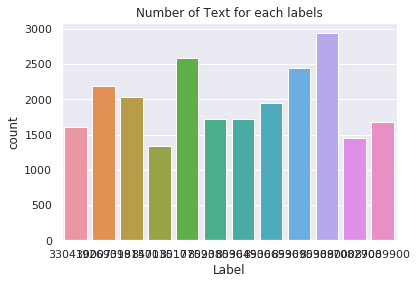

In [9]:
sns.countplot(df_train.label)
plt.xlabel('Label')
plt.title('Number of Text for each labels')

#### Generate WordClouds

Generate wordclouds (frequency of words used) to see what kind of text is there in each label

In [10]:
df_train[df_train['label']==85389000].head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for circuit breaker captive consumption
2,85389000,lv ma pd trip unit for cvs parts of circuit breakers
3,85389000,lv na p trip unit for cvs switch parts of circuit breaker
4,85389000,lv tmd pd trip unit for cvs parts of circuitbreakers


In [11]:
def get_concat_text(texts):
    """
    returns concated string for given list of strings
    """
    result=""
    for each in texts:
        result+= " ".join(each.split())
        result+= " "
    return result

In [12]:
def generate_wordcloud(texts,label):
    """Create and generate a word cloud image:"""
    wordcloud = WordCloud().generate(get_concat_text(texts))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(label)
    plt.show()

In [13]:
def generate_wc_labels(labels):
    for label in labels:
        generate_wordcloud(list(df_train[df_train['label']==label]["text"].values),label)
    return None

In [14]:
all_labels = list(df_train["label"].unique())

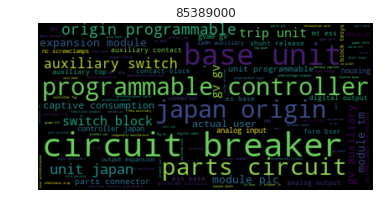

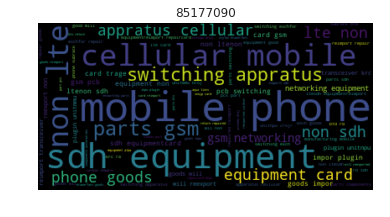

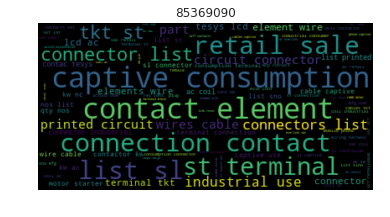

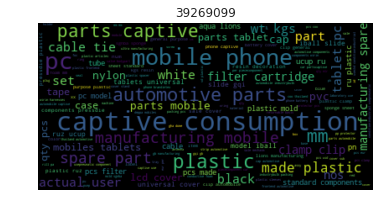

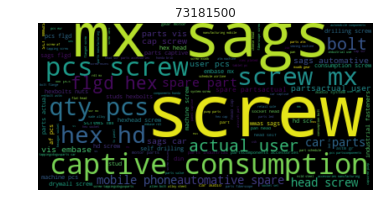

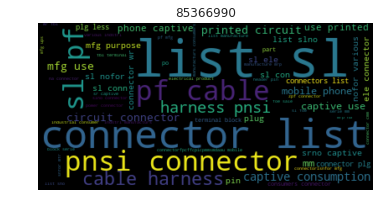

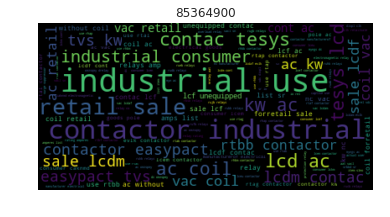

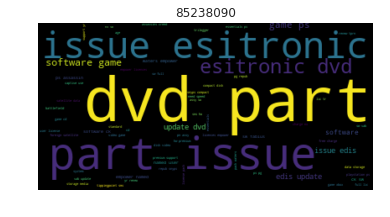

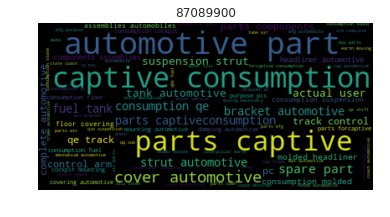

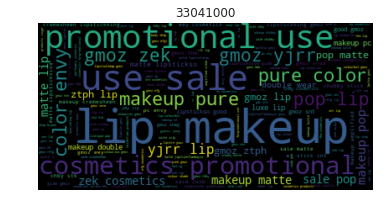

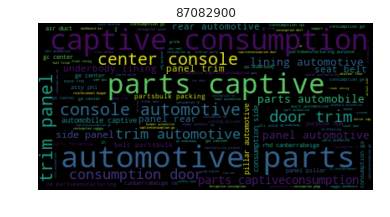

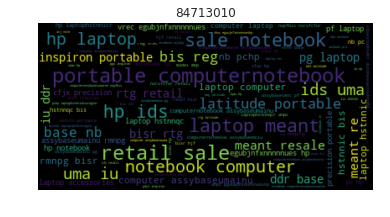

In [14]:
generate_wc_labels(all_labels)

#### Processing train and test data

In [17]:
X = df_train.text
Y= df_train.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [18]:
# converting target to one hot encoding
Y= to_categorical(Y)

#### Splitting into Train and validation set

In [19]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.15)

### Tokenizing the text data

In [21]:
max_words =12831 #1000
max_len = 20
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)


In [22]:
test_sequences = tokenizer.texts_to_sequences(X_val)

print("The maximum length of text is:",max([len(each) for each in test_sequences]))

The maximum length of text is: 21


In [23]:
# padding the tokenized text to fixed length i.e max_len
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [24]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 12828 unique tokens.


## Building the model

In [25]:
embedding_dim = 32

In [26]:
def model():
    inputs = Input(name='inputs',shape=[max_len])
    x = Embedding(input_dim=max_words,output_dim=embedding_dim,input_length=max_len)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
    x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)
    x = SpatialDropout1D(0.35)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(12,name='out_layer',activation='softmax')(x)
    output = Model(inputs=inputs,outputs=x)
    return output

In [27]:
model = model()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

W1125 11:50:37.660882 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1125 11:50:37.895182 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1125 11:50:37.896607 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1125 11:50:38.440164 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.place

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 32)       410592      inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 256)      164864      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 64)       49216       bidirectional_1[0][0]            
__________________________________________________________________________________________________
spatial_dr

#### Training the model

In [28]:
# Tensorboard config
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [29]:
# save only best model 
mc = ModelCheckpoint('model/best_model2.h5', monitor='val_acc', mode='max', save_best_only=True)

In [30]:
EPOCHS = 50

training_history = model.fit(
    sequences_matrix, # input
    Y_train, # output
    batch_size=128,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[tensorboard_callback,EarlyStopping(monitor='val_loss',mode='min',min_delta=0.0001,patience=20),mc],
)

print("Training Finished")

W1125 11:51:11.392940 140660337080128 deprecation.py:323] From /home/rosebay/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16057 samples, validate on 4015 samples


W1125 11:51:14.011829 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1125 11:51:14.013758 140660337080128 deprecation_wrapper.py:119] From /home/rosebay/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
16057/16057 [==============================] - 11s 711us/step - loss: 1.5563 - acc: 0.4374 - val_loss: 0.7161 - val_acc: 0.7691
Epoch 2/50
16057/16057 [==============================] - 8s 517us/step - loss: 0.5717 - acc: 0.8068 - val_loss: 0.4090 - val_acc: 0.8682
Epoch 3/50
16057/16057 [==============================] - 9s 537us/step - loss: 0.2839 - acc: 0.9081 - val_loss: 0.3396 - val_acc: 0.9006
Epoch 4/50
16057/16057 [==============================] - 9s 544us/step - loss: 0.1708 - acc: 0.9464 - val_loss: 0.3276 - val_acc: 0.9071
Epoch 5/50
16057/16057 [==============================] - 9s 542us/step - loss: 0.1121 - acc: 0.9656 - val_loss: 0.3230 - val_acc: 0.9138
Epoch 6/50
16057/16057 [==============================] - 9s 544us/step - loss: 0.0804 - acc: 0.9770 - val_loss: 0.3568 - val_acc: 0.9173
Epoch 7/50
16057/16057 [==============================] - 9s 563us/step - loss: 0.0636 - acc: 0.9809 - val_loss: 0.3801 - val_acc: 0.9171
Epoch 8/50
16057/16057 [=========

In [31]:
print("Average train loss: ", round(np.average(training_history.history['loss']),2))
print("Average val loss: ", round(np.average(training_history.history['val_loss']),2))
print("Average train acc: ", round(np.average(training_history.history['acc'])*100,2))
print("Average val acc: ", round(np.average(training_history.history['val_acc'])*100,2))

Average train loss:  0.13
Average val loss:  0.44
Average train acc:  95.48
Average val acc:  90.69


#### Evaluating the Val data using Best Model

In [32]:
def evaluate_val(keras_model,X,Y,max_len = max_len):
    val_sequences = tokenizer.texts_to_sequences(X)
    val_sequences_matrix = sequence.pad_sequences(val_sequences,maxlen=max_len)
    accr = keras_model.evaluate(val_sequences_matrix,Y)
    print('Validation set\n  Loss: {:0.3f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]*100))
    return accr


In [33]:
#loading best model
best_model = load_model('model/best_model2.h5')

In [34]:
evaluate_val(best_model,X_val, Y_val)

3543/3543 [==============================] - 1s 301us/step
Validation set
  Loss: 0.402
  Accuracy: 92.27


[0.402073803499463, 0.9226644085081425]

### Prediction of Test Set

In [35]:
test_sequences = tokenizer.texts_to_sequences(df_test['text'].values)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [36]:
Y_predicted = le.inverse_transform(np.argmax(best_model.predict(test_sequences_matrix),axis=1))

In [37]:
df_test["predicted_class"] = Y_predicted 

In [38]:
df_test.head()

,text,predicted_class
0,lv tmd pd trip unit for nh parts of circuit breaker,85389000
1,module tm analog outputs analog output expansion module for plc tmaq,85389000
2,command group t iii mechanismt p parts forcircuit breaker,85389000
3,parts of relayelectrical contact issu e f xxup,85389000
4,parts for programmable logic controllers dm parts for plcs printed circuit assembl coo at,85389000


In [39]:
df_test.to_csv("output/predicted_test.csv",index=False)